In [231]:
import os
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from PIL import Image, ImageOps
from scipy import ndimage
from ultralytics import YOLO
from collections import defaultdict

In [232]:
model = tf.lite.Interpreter(model_path="model/model.tflite")
model.allocate_tensors()

In [233]:
input_details = model.get_input_details()
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]

In [234]:
def crop_image(image):
    cropped_image = None
    
    old_size = image.size
    desired_ratio = input_size[0] / input_size[1]
    old_ratio = old_size[0] / old_size[1]

    if old_ratio < desired_ratio:
        new_size = (old_size[0], int(old_size[0] / desired_ratio))
    else:
        new_size = (int(old_size[1] * desired_ratio), old_size[1])

    delta_w = new_size[0] - old_size[0]
    delta_h = new_size[1] - old_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    cropped_image = ImageOps.expand(image, padding)
    
    return cropped_image

In [235]:
def preprocess_image(cropped_image):
    image_for_prediction = None
    
    resized_image = cropped_image.resize(input_size, Image.BILINEAR)
    
    image_for_prediction = np.asarray(resized_image).astype(np.float32)
    image_for_prediction = np.expand_dims(image_for_prediction, 0)
    image_for_prediction = image_for_prediction / 127.5 - 1
    
    return image_for_prediction

In [236]:
def segment_image(image_for_prediction, cropped_image):
    segmentation_map = None
    
    model.set_tensor(input_details[0]['index'], image_for_prediction)
    model.invoke()
    
    output_details = model.get_output_details()
    output_data = model.get_tensor(output_details[0]['index'])
    
    width, height = cropped_image.size
    
    segmentation_map = tf.argmax(tf.image.resize(output_data, (height, width)), axis=3)
    segmentation_map = tf.squeeze(segmentation_map).numpy().astype(np.int8)
    
    condition = (segmentation_map == 0) | (segmentation_map == 1) | \
                (segmentation_map == 11) | (segmentation_map == 13)
    segmentation_map = np.where(condition, segmentation_map, 19)
    
    return segmentation_map

In [237]:
def create_cityscapes_label_colormap():
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[11] = [220, 20, 60]
  colormap[13] = [0, 0, 142]
  colormap[19] = [128, 128, 128]

  return colormap

In [238]:
def label_to_color_image(label):
  colormap = create_cityscapes_label_colormap()

  return colormap[label]

In [239]:
def create_overlay_image(image, segmentation_map, alpha=0.5):
    """Create an overlay image combining the original image with segmentation map"""
    seg_image = label_to_color_image(segmentation_map).astype(np.uint8)
    image_np = np.array(image)

    overlay = (image_np * (1 - alpha) + seg_image * alpha).astype(np.uint8)
    return overlay

def save_overlay_image(image, segmentation_map, filename, alpha=0.5):
    """Create and save overlay image"""
    overlay = create_overlay_image(image, segmentation_map, alpha)
    overlay_pil = Image.fromarray(overlay)
    overlay_pil.save(filename)
    return overlay


In [240]:
def visualize(image, segmentation_map):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(1, 3, 2)
  seg_image = label_to_color_image(segmentation_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(1, 3, 3)
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.5)
  plt.axis('off')
  plt.title('segmentation overlay')

  plt.grid('off')
  plt.show()

In [241]:
def extract_bounding_boxes(segmentation_map, class_id):
    mask = (segmentation_map == class_id).astype(np.uint8)
    labeled, num_features = ndimage.label(mask)
    boxes = []
    for region in range(1, num_features + 1):
        coords = np.column_stack(np.where(labeled == region))
        if coords.size == 0:
            continue
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        boxes.append((x_min, y_min, x_max, y_max))
    return boxes

In [242]:
images_path = "data/"
images = [Image.open(images_path + image_name) for image_name in os.listdir(images_path)]

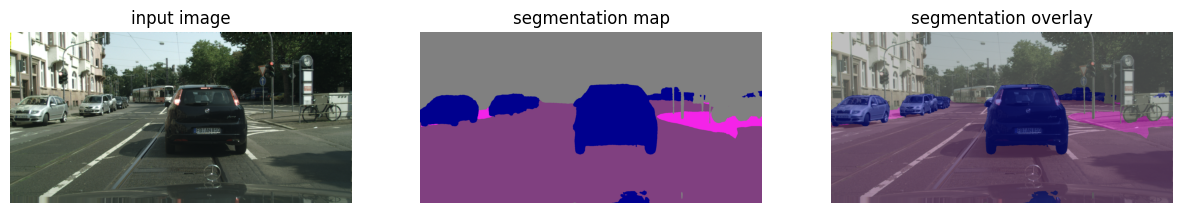

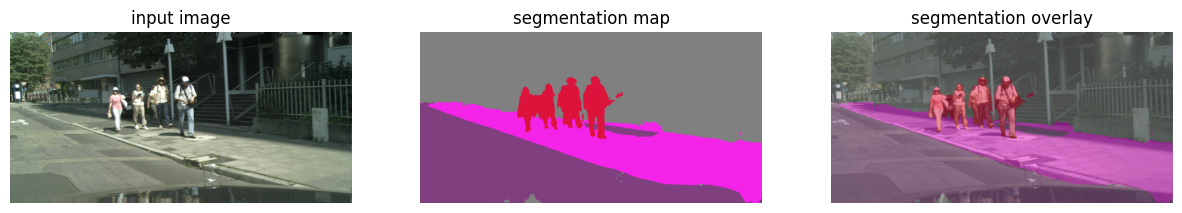

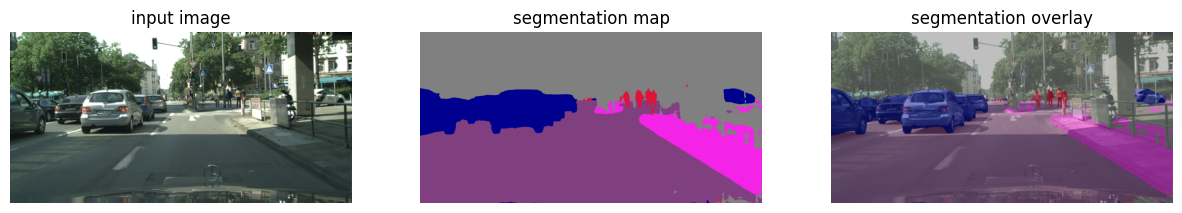

In [243]:
segmentation_maps = []
overlay_images = []

for i, image in enumerate(images):
    cropped_image = crop_image(image)
    image_for_prediction = preprocess_image(cropped_image)
    segmentation_map = segment_image(image_for_prediction, cropped_image)
    
    segmentation_maps.append(segmentation_map)
    
    overlay = save_overlay_image(
        cropped_image, 
        segmentation_map, 
        f"segmentation_maps/overlay_{i}.png", 
        alpha=0.5
    )
    overlay_images.append(overlay)
    
    if i < 3:
        visualize(cropped_image, segmentation_map)

In [244]:
yolo_model = YOLO("yolov8n.pt")

In [245]:
detection_stats = []

for i, image in enumerate(images):
    img_np = np.array(image)
    results = yolo_model(img_np, verbose=False)
    
    # Extract detection information
    result = results[0]
    
    # Get detection data
    boxes = result.boxes
    stats = {
        "image_id": i,
        "image_shape": img_np.shape,
        "detections": [],
        "summary": {},
        "total_detections": len(boxes) if boxes is not None else 0
    }
    
    if boxes is not None:
        # Count detections by class
        class_counts = defaultdict(int)
        
        for j in range(len(boxes)):
            box = boxes[j]
            class_id = int(box.cls.item())
            class_name = result.names[class_id]
            confidence = float(box.conf.item())
            bbox = box.xyxy[0].tolist()
            
            # Add individual detection
            stats["detections"].append({
                "class_id": class_id,
                "class_name": class_name,
                "confidence": confidence,
                "bbox": bbox
            })
            
            # Count for summary
            class_counts[class_name] += 1
        
        stats["summary"] = dict(class_counts)
    
    detection_stats.append(stats)

In [246]:
images_path = "segmentation_maps/"
maps = [Image.open(images_path + image_name) for image_name in os.listdir(images_path)]

In [247]:
segmentation_detection_stats = []

for i, image in enumerate(maps):
    img_np = np.array(image)
    results = yolo_model(img_np, verbose=False)
    
    # Extract detection information
    result = results[0]
    
    # Get detection data
    boxes = result.boxes
    stats = {
        "image_id": i,
        "image_shape": img_np.shape,
        "detections": [],
        "summary": {},
        "total_detections": len(boxes) if boxes is not None else 0
    }
    
    if boxes is not None:
        # Count detections by class
        class_counts = defaultdict(int)
        
        for j in range(len(boxes)):
            box = boxes[j]
            class_id = int(box.cls.item())
            class_name = result.names[class_id]
            confidence = float(box.conf.item())
            bbox = box.xyxy[0].tolist()
            
            # Add individual detection
            stats["detections"].append({
                "class_id": class_id,
                "class_name": class_name,
                "confidence": confidence,
                "bbox": bbox
            })
            
            # Count for summary
            class_counts[class_name] += 1
        
        stats["summary"] = dict(class_counts)
    
    segmentation_detection_stats.append(stats)